In [5]:
import os
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt

In [6]:
from pyrep import PyRep
from pyrep.objects.vision_sensor import VisionSensor
from pyrep.objects.shape import Shape
from pyrep.const import PrimitiveShape
from pyrep.objects.dummy import Dummy

In [10]:
#pyrep wrapper is requried 
pr = PyRep()

#path the the coppelia scene file for testing
SCENE_FILE = './scenes/camera_calibration_dev_test_intrinsics.ttt'

In [11]:
#launch the scene and start the simulation
pr.launch(SCENE_FILE)
pr.start()
pr.step()

In [34]:
#get the object handles

tip = Dummy('Sawyer_tip')
print('tip_position: ', tip.get_position())

vs_front = VisionSensor('Vision_front')
#vs_front = VisionSensor('Vision_front_512x512')

print('vs_position: ', vs_front.get_position())

obj = Shape('Sphere')
obj_xyz_wf = obj.get_position()
obj_xyz_cf = obj.get_position(relative_to=tip)

print('obs_wf: ', obj_xyz_wf)
print('obs_cf: ', obj_xyz_cf)

tip_position:  [0.  0.  0.2]
vs_position:  [0.  0.  0.2]
obs_wf:  [ 0.0577413  -0.05160957  0.00499994]
obs_cf:  [0.0577413  0.05160954 0.19500007]


In [35]:
def capture_rgb():
    rgb = vs_front.capture_rgb() * 255
    rgb = rgb.astype(np.uint8)
    return rgb
def capture_grey():
    rgb = capture_rgb()
    grey = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)
    return grey

In [36]:
def find_uv(img):
    #find the sphere in the scene using color diff
    result = np.where(img == 0)
    u = result[1].mean()
    v = result[0].mean()
    return u,v

def move_obj(obj):
    #move object (sphere) randomly in the scene
    obj_current_position = obj.get_position()
    x,y,z = obj_current_position
    
    xmax,xmin = 0.1, -0.1
    ymax,ymin = 0.1, -0.1
    
    xtarget = xmin + np.random.rand()*(xmax-xmin)
    ytarget = ymin + np.random.rand()*(ymax-ymin)
    ztarget = z
    
    obj.set_position([xtarget,ytarget,ztarget])
    pr.step()

def estimate_uv(K,obj_pos_cf):
    #estimate image [u,v] coord using the inrinsic matrix + object position in camera frame
    T = np.array([[-1,0,128], [0,-1,128], [0,0,1]])
    Kh = np.dot(T,K)
    
    # 1.Matrix product: [K]*[x,y,z]_camereFrame
    # 2.Normalize it to get [u,v,1]
    uh,vh,_ = np.dot(Kh,obj_pos_cf)/obj_pos_cf[2]
    return uh,vh

In [37]:
#ground truth values 
fx = 91.40147243149534
fy = 91.40147243149534
cx = 64
cy = 64

Kgt = np.array([[fx, 0, cx],[0, fy, cy], [0, 0, 1]])

#estimated values -- using the other notebook
fx = 96.69022551364957
fy = 96.35145108202612
cx = 63.49752448394732
cy = 60.06080558785592

K = np.array([[fx, 0, cx],[0, fy, cy], [0, 0, 1]])

In [38]:
img_list = []
uv_gt  = []
uv_est = []
N_tests = 10

for i in range(N_tests):
    move_obj(obj)
    img = capture_grey()
    u,v = find_uv(img)
    uv_gt.append((u,v))
    
    obj_pos_cf = obj.get_position(relative_to=tip)
    uh,vh = estimate_uv(Kgt,obj_pos_cf)
    uv_est.append((uh,vh))
    
    img_list.append(img)


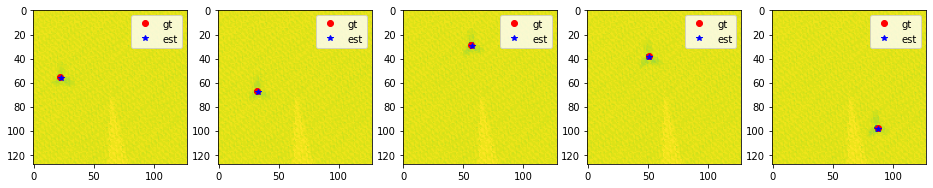

In [39]:
fig = plt.figure(figsize=(16,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(img_list[i])
    plt.plot(uv_gt[i][0],uv_gt[i][1], 'or', label = 'gt') #ground truth
    plt.plot(uv_est[i][0], uv_est[i][1], '*b', label='est') #estimated using intrinsics
    plt.legend()
plt.show()